Temps d'exécution du réseau de neurones : 2.288


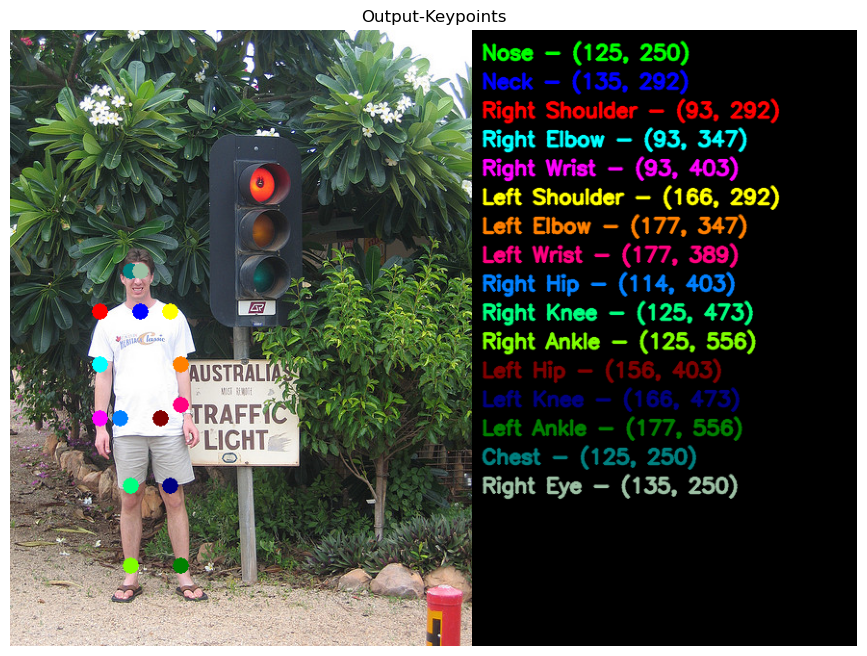

In [36]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# Déclaration des variables globales
frameCopy = None
points = []

def main():
    global frameCopy, points  #  les variables globales

    #  l'image   on peut chnager l'image ici pour voir le 
    frame = cv2.imread("./HumanPoses/pose7.jpg")

    if frame is None:
        print("Erreur : Impossible de lire l'image. Vérifiez le chemin ou l'intégrité du fichier.")
        return

    #  le chemin vers ces 2 fichiers
    protoFile = "./openpose/models/pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "./openpose/models/pose/coco/pose_iter_440000.caffemodel"

    nPoints = 18
    keypoints_names = [
        "Nose", "Neck", "Right Shoulder", "Right Elbow", "Right Wrist",
        "Left Shoulder", "Left Elbow", "Left Wrist", "Right Hip",
        "Right Knee", "Right Ankle", "Left Hip", "Left Knee",
        "Left Ankle", "Chest", "Right Eye", "Left Eye",
        "Right Ear", "Left Ear", "Background"
    ]
    
    # Couleurs pour chaque point clé
    colors = [
        (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),
        (255, 0, 255), (0, 255, 255), (0, 128, 255), (128, 0, 255),
        (255, 128, 0), (128, 255, 0), (0, 255, 128), (0, 0, 128),
        (128, 0, 0), (0, 128, 0), (128, 128, 0), (164, 192, 156),
        (55, 85, 98), (192, 192, 192), (255, 128, 128)
    ]
    
    #  le réseau de neurones en mémoire
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    t = time.time()

    #  les dimensions de l'image en entrée
    inWidth = 368
    inHeight = 368

    #  le frame à alimenter au réseau
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    #  l'objet préparé comme blob d'entrée du réseau
    net.setInput(inpBlob)
    output = net.forward()

    print("Temps d'exécution du réseau de neurones : {:.3f}".format(time.time() - t))

    H = output.shape[2]
    W = output.shape[3]
    points = []
    
    for i in range(nPoints):
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold:
            # on ignore les points 14, 15, 16, et 17
            if i in [16, 17]:
                points.append(None)
                continue
            
            # on augmente le rayon du cercle pour les points clés
            cv2.circle(frameCopy, (int(x), int(y)), 8, colors[i], thickness=-1, lineType=cv2.FILLED)
            points.append((int(x), int(y)))
        else:
            points.append(None)

    # crea d'une image vide pour afficher les légendes
    height, width, _ = frameCopy.shape
    combined_width = width + 400  # Largeur pour la zone de texte
    combined_image = np.zeros((height, combined_width, 3), dtype=np.uint8)
    
    # on colle l'image avec les points clés à gauche
    combined_image[:height, :width] = frameCopy

    # on ajoute les légendes à droite
    for idx, point in enumerate(points):
        if point is not None:
            cv2.putText(combined_image, f"{keypoints_names[idx]} - ({point[0]}, {point[1]})", 
                        (width + 10, 30 + idx * 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[idx], 2, lineType=cv2.LINE_AA)
        else:
            #  pas afficher pour les points ignorés
            if idx in [14, 15, 16, 17]:
                continue
            cv2.putText(combined_image, f"{keypoints_names[idx]} - Non détecté", 
                        (width + 10, 30 + idx * 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, lineType=cv2.LINE_AA)

    # on affiche l'image combinée avec Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # on affiche ps les axes
    plt.title('Output-Keypoints')
    plt.show()


if __name__ == "__main__":
    main()


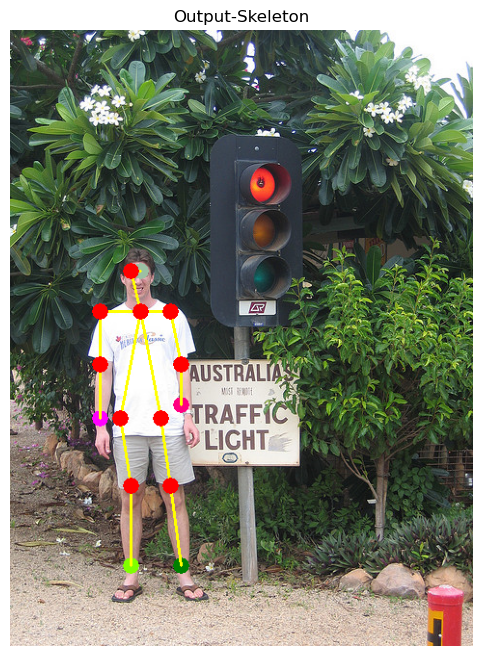

In [37]:
#  les paires de points pour le squelette
POSE_PAIRS = [
    (1, 0), (1, 2), (2, 3), (3, 4), (1, 5), (5, 6),
    (6, 7), (1, 8), (8, 9), (9, 10), (1, 11), (11, 12),
    (12, 13), (1, 14), (14, 15), (0, 16), (0, 17)
]

def draw_skeleton(frame, points):
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        
        if points[partA] and points[partB]:
            # on dessine la ligne entre les points
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
            # on dessine un cercle pour chaque point
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    # on affiche l'image avec Matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Output-Skeleton')
    plt.show()

# on appele cette fonction avec les points détectés
draw_skeleton(frameCopy, points)


In [38]:
# Dictionnaire des points avec leurs descriptions
points_descriptions = {
    0: "nez",
    1: "cou",
    2: "épaule droite",
    3: "coude droit",
    4: "poignet droit",
    5: "epaule gauche",
    6: "coude gauche",
    7: "poignet gauche",
    8: "hanche droite",
    9: "genoux droit",
    10: "cheville droite",
    11: "hanche gauche",
    12: "genoux gauche",
    13: "cheville gauche"
}

# Liste des points requis
required_points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Points nécessaires pour estimer les mesures

# on verifie les points manquants
missing_points = [i for i in required_points if points[i] is None]

if missing_points:
    print(f"Erreur : Les points clés suivants sont manquants : {missing_points}")
    exit()
else:
    # Tous les points requis sont disponibles
    print("Tous les points requis pour le calcul des distances sont disponibles.")
    
    # on affiche les points disponibles avec détails
    print("Détails des points disponibles pour le calcul :")
    for idx in required_points:
        coord = points[idx]
        description = points_descriptions[idx]
        print(f"Le point {description} (point {idx}) est situé à {coord[0]} pixels vers la droite et {coord[1]} pixels vers le bas.")


Tous les points requis pour le calcul des distances sont disponibles.
Détails des points disponibles pour le calcul :
Le point cou (point 1) est situé à 135 pixels vers la droite et 292 pixels vers le bas.
Le point épaule droite (point 2) est situé à 93 pixels vers la droite et 292 pixels vers le bas.
Le point coude droit (point 3) est situé à 93 pixels vers la droite et 347 pixels vers le bas.
Le point poignet droit (point 4) est situé à 93 pixels vers la droite et 403 pixels vers le bas.
Le point epaule gauche (point 5) est situé à 166 pixels vers la droite et 292 pixels vers le bas.
Le point coude gauche (point 6) est situé à 177 pixels vers la droite et 347 pixels vers le bas.
Le point poignet gauche (point 7) est situé à 177 pixels vers la droite et 389 pixels vers le bas.
Le point hanche droite (point 8) est situé à 114 pixels vers la droite et 403 pixels vers le bas.
Le point genoux droit (point 9) est situé à 125 pixels vers la droite et 473 pixels vers le bas.
Le point chevill

In [39]:
import math
from statistics import mean

def calculate_distance(pointA, pointB):
    """Calculer la distance entre deux points."""
    if pointA is None or pointB is None:
        return None
    return math.sqrt((pointA[0] - pointB[0]) ** 2 + (pointA[1] - pointB[1]) ** 2)

def calculate_body_metrics(points):
    # Longueurs des bras
    longueur_bras_droit_epaule_coude = calculate_distance(points[2], points[3])  # Épaule droite à coude droit
    longueur_bras_droit_coude_poignet = calculate_distance(points[3], points[4])  # Coude droit à poignet droit
    longueur_bras_droit_total = longueur_bras_droit_epaule_coude + longueur_bras_droit_coude_poignet

    longueur_bras_gauche_epaule_coude = calculate_distance(points[5], points[6])  # Épaule gauche à coude gauche
    longueur_bras_gauche_coude_poignet = calculate_distance(points[6], points[7])  # Coude gauche à poignet gauche
    longueur_bras_gauche_total = longueur_bras_gauche_epaule_coude + longueur_bras_gauche_coude_poignet

    # Longueurs des jambes
    longueur_jambe_droite_hanche_genou = calculate_distance(points[8], points[9])  # Hanche droite à genou droit
    longueur_jambe_droite_genou_cheville = calculate_distance(points[9], points[10])  # Genou droit à cheville droite
    longueur_jambe_droite_total = longueur_jambe_droite_hanche_genou + longueur_jambe_droite_genou_cheville

    longueur_jambe_gauche_hanche_genou = calculate_distance(points[11], points[12])  # Hanche gauche à genou gauche
    longueur_jambe_gauche_genou_cheville = calculate_distance(points[12], points[13])  # Genou gauche à cheville gauche
    longueur_jambe_gauche_total = longueur_jambe_gauche_hanche_genou + longueur_jambe_gauche_genou_cheville

    # Largeur des épaules
    largeur_epaule = calculate_distance(points[2], points[5])  # Épaule droite à épaule gauche

    # Longueur du torse
    longueur_torse = calculate_distance(points[1], points[8]) if points[8] is not None else calculate_distance(points[1], points[11])  # Cou à hanche droite ou hanche gauche

    # Calcul des longueurs supplémentaires
    longueur_manche_courte = max(longueur_bras_droit_epaule_coude, longueur_bras_gauche_epaule_coude)
    longueur_manche_longue = max(longueur_bras_droit_total, longueur_bras_gauche_total)
    longueur_culotte = max(longueur_jambe_droite_hanche_genou, longueur_jambe_gauche_hanche_genou)
    longueur_pantalon = max(longueur_jambe_droite_total, longueur_jambe_gauche_total)

    # Récupérer les résultats pour affichage (sans tour de poitrine et tour de hanche)
    results = {
        "longueur_bras_droit_epaule_coude": longueur_bras_droit_epaule_coude,
        "longueur_bras_droit_coude_poignet": longueur_bras_droit_coude_poignet,
        "Longueur totale du bras droit": longueur_bras_droit_total,
        "longueur_bras_gauche_epaule_coude": longueur_bras_gauche_epaule_coude,
        "longueur_bras_gauche_coude_poignet": longueur_bras_gauche_coude_poignet,
        "Longueur totale du bras gauche": longueur_bras_gauche_total,
        "longueur_jambe_droite_hanche_genou": longueur_jambe_droite_hanche_genou,
        "longueur_jambe_droite_genou_cheville": longueur_jambe_droite_genou_cheville,
        "Longueur totale de la jambe droite": longueur_jambe_droite_total,
        "longueur_jambe_gauche_hanche_genou": longueur_jambe_gauche_hanche_genou,
        "longueur_jambe_gauche_genou_cheville": longueur_jambe_gauche_genou_cheville,
        "Longueur totale de la jambe gauche": longueur_jambe_gauche_total,
        "Largeur des epaules": largeur_epaule,
        "Longueur du torse": longueur_torse,
        "Longueur de la manche courte": longueur_manche_courte,
        "Longueur de la manche longue": longueur_manche_longue,
        "Longueur de la culotte": longueur_culotte,
        "Longueur du pantalon": longueur_pantalon
    }
    
    
    return results


body_metrics = calculate_body_metrics(points)

# Afficher les mesures
print("Aperçu des Mesures :")
for metric, value in body_metrics.items():
    print(f"{metric}: {value:.2f} pixels")

Aperçu des Mesures :
longueur_bras_droit_epaule_coude: 55.00 pixels
longueur_bras_droit_coude_poignet: 56.00 pixels
Longueur totale du bras droit: 111.00 pixels
longueur_bras_gauche_epaule_coude: 56.09 pixels
longueur_bras_gauche_coude_poignet: 42.00 pixels
Longueur totale du bras gauche: 98.09 pixels
longueur_jambe_droite_hanche_genou: 70.86 pixels
longueur_jambe_droite_genou_cheville: 83.00 pixels
Longueur totale de la jambe droite: 153.86 pixels
longueur_jambe_gauche_hanche_genou: 70.71 pixels
longueur_jambe_gauche_genou_cheville: 83.73 pixels
Longueur totale de la jambe gauche: 154.44 pixels
Largeur des epaules: 73.00 pixels
Longueur du torse: 112.97 pixels
Longueur de la manche courte: 56.09 pixels
Longueur de la manche longue: 111.00 pixels
Longueur de la culotte: 70.86 pixels
Longueur du pantalon: 154.44 pixels


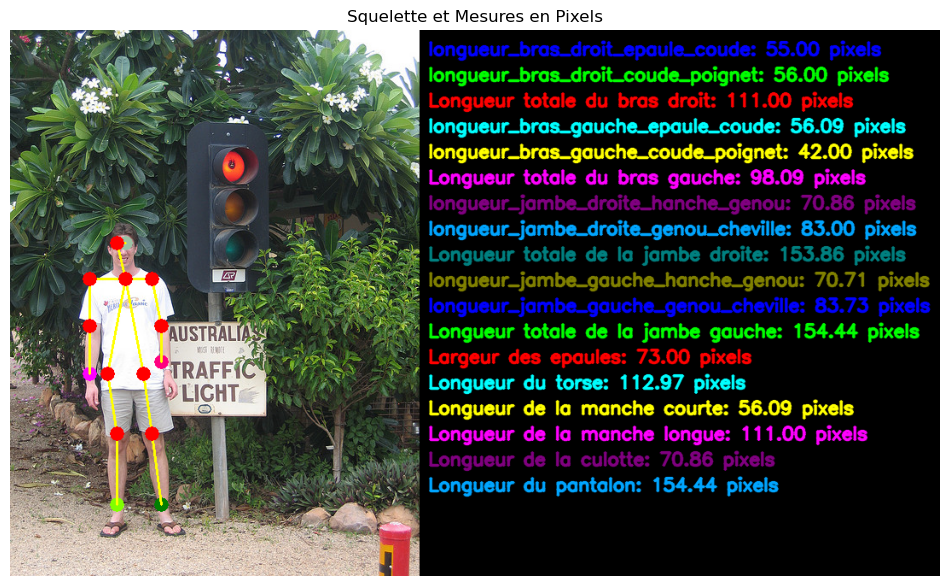

In [40]:
body_metrics = calculate_body_metrics(points)

# Créer une image pour les mesures
height, width, _ = frameCopy.shape

# Palette de couleurs pour les mesures
colors = [
    (255, 0, 0),   # Rouge
    (0, 255, 0),   # Vert
    (0, 0, 255),   # Bleu
    (255, 255, 0), # Jaune
    (0, 255, 255), # Cyan
    (255, 0, 255), # Magenta
    (128, 0, 128), # Violet
    (255, 165, 0), # Orange
    (128, 128, 0), # Olive
    (0, 128, 128)  # Teal
]

# on calcule la largeur nécessaire pour l'arrière-plan noir
max_text_width = max([cv2.getTextSize(f"{metric}: {value:.2f} pixels", 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0][0] for metric, value in body_metrics.items()])
black_background_width = max_text_width + 20  # Ajout d'un espace supplémentaire

# on crée une image noire avec la largeur calculée
black_background = np.zeros((height, black_background_width, 3), dtype=np.uint8)

# on crée  une image combinée avec la largeur ajustée
combined_width = width + black_background_width
combined_image = np.zeros((height, combined_width, 3), dtype=np.uint8)

# on colle l'image avec le squelette à gauche
combined_image[:height, :width] = frameCopy

# on colle l'image noire à droite
combined_image[:height, width:] = black_background

# on affiche les résultats sur l'image noire
y_offset = 30  # Décalage vertical pour le texte
for idx, (metric, value) in enumerate(body_metrics.items()):
    color = colors[idx % len(colors)]  # Choisir une couleur pour chaque mesure
    cv2.putText(combined_image, f"{metric}: {value:.2f} pixels", 
                (width + 10, y_offset + idx * 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, lineType=cv2.LINE_AA)

# on affiche l'image combinée avec les résultats
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.title('Squelette et Mesures en Pixels')
plt.show()

Mesures corporelles en centimètres :
longueur_bras_droit_epaule_coude: 1.46 cm
longueur_bras_droit_coude_poignet: 1.48 cm
Longueur totale du bras droit: 2.94 cm
longueur_bras_gauche_epaule_coude: 1.48 cm
longueur_bras_gauche_coude_poignet: 1.11 cm
Longueur totale du bras gauche: 2.60 cm
longueur_jambe_droite_hanche_genou: 1.87 cm
longueur_jambe_droite_genou_cheville: 2.20 cm
Longueur totale de la jambe droite: 4.07 cm
longueur_jambe_gauche_hanche_genou: 1.87 cm
longueur_jambe_gauche_genou_cheville: 2.22 cm
Longueur totale de la jambe gauche: 4.09 cm
Largeur des epaules: 1.93 cm
Longueur du torse: 2.99 cm
Longueur de la manche courte: 1.48 cm
Longueur de la manche longue: 2.94 cm
Longueur de la culotte: 1.87 cm
Longueur du pantalon: 4.09 cm


640

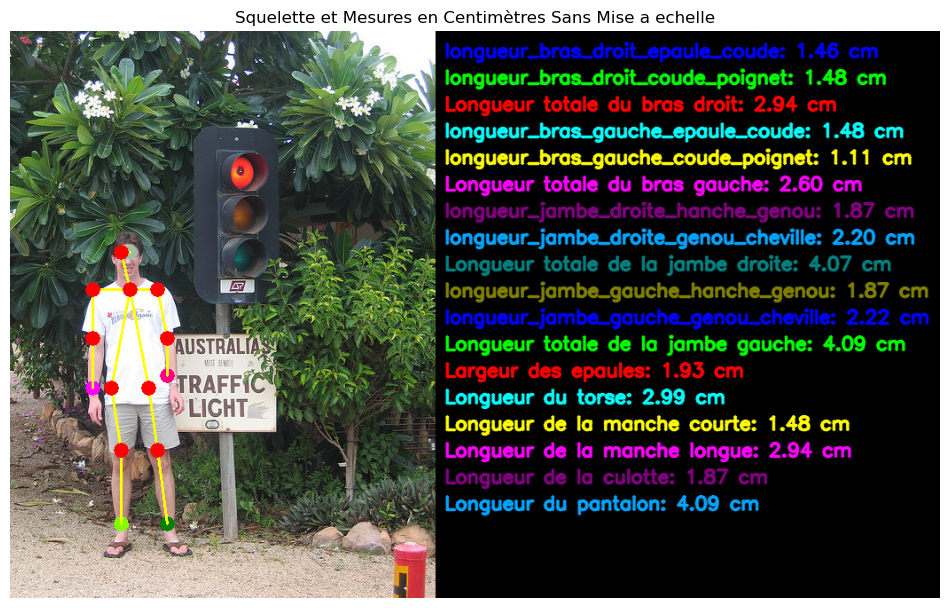

In [41]:
# Fonction pour convertir les pixels en centimètres
def pixels_to_cm(pixels, dpi=96):
    """Convertir les pixels en centimètres en utilisant le DPI."""
    return (pixels / dpi) * 2.54

# Exemple de points et calcul des métriques corporelles 
body_metrics = calculate_body_metrics(points)


# on affiche les mesures avant l'image
print("Mesures corporelles en centimètres :")
for metric, value in body_metrics.items():
    if value is not None:
        cm_value = pixels_to_cm(value)  # Convertir en cm
        print(f"{metric}: {cm_value:.2f} cm")

# on creee une image pour les mesures
height, width, _ = frameCopy.shape
display(height)

# Palette de couleurs pour les mesures
colors = [
    (255, 0, 0),   # Rouge
    (0, 255, 0),   # Vert
    (0, 0, 255),   # Bleu
    (255, 255, 0), # Jaune
    (0, 255, 255), # Cyan
    (255, 0, 255), # Magenta
    (128, 0, 128), # Violet
    (255, 165, 0), # Orange
    (128, 128, 0), # Olive
    (0, 128, 128)  # Teal
]

# on calcule la largeur nécessaire pour l'arrière-plan noir
max_text_width = max([cv2.getTextSize(f"{metric}: {pixels_to_cm(value):.2f} cm", 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0][0] 
                      for metric, value in body_metrics.items() if value is not None], default=0)

black_background_width = max_text_width + 20  # Ajout d'un espace supplémentaire

# on cree une image noire avec la largeur calculée
black_background = np.zeros((height, black_background_width, 3), dtype=np.uint8)

# on cree  une image combinée avec la largeur ajustée
combined_width = width + black_background_width
combined_image = np.zeros((height, combined_width, 3), dtype=np.uint8)

# on cree  l'image avec le squelette à gauche
combined_image[:height, :width] = frameCopy

# on cree l'image noire à droite
combined_image[:height, width:] = black_background

# on affiche les résultats sur l'image noire
y_offset = 30  # Décalage vertical pour le texte
dpi = 96  # DPI standard pour la conversion

for idx, (metric, value) in enumerate(body_metrics.items()):
    if value is not None:  # on verifie que la valeur n'est pas None
        color = colors[idx % len(colors)]  # choisissons une couleur pour chaque mesure
        cm_value = pixels_to_cm(value, dpi)  # on va convertir en cm
        cv2.putText(combined_image, f"{metric}: {cm_value:.2f} cm", 
                    (width + 10, y_offset + idx * 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, lineType=cv2.LINE_AA)

# on affiche l'image combinée avec les résultats
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # on n'affiche pas  les axes
plt.title('Squelette et Mesures en Centimètres Sans Mise a echelle')
plt.show()


308.86890422961 8.172156424408431
Mesures corporelles réelles en centimètres :
longueur_bras_droit_epaule_coude: 34.97 cm
longueur_bras_droit_coude_poignet: 35.60 cm
Longueur totale du bras droit: 70.57 cm
longueur_bras_gauche_epaule_coude: 35.66 cm
longueur_bras_gauche_coude_poignet: 26.70 cm
Longueur totale du bras gauche: 62.36 cm
longueur_jambe_droite_hanche_genou: 45.05 cm
longueur_jambe_droite_genou_cheville: 52.77 cm
Longueur totale de la jambe droite: 97.81 cm
longueur_jambe_gauche_hanche_genou: 44.95 cm
longueur_jambe_gauche_genou_cheville: 53.23 cm
Longueur totale de la jambe gauche: 98.18 cm
Largeur des epaules: 46.41 cm
Longueur du torse: 71.82 cm
Longueur de la manche courte: 35.66 cm
Longueur de la manche longue: 70.57 cm
Longueur de la culotte: 45.05 cm
Longueur du pantalon: 98.18 cm


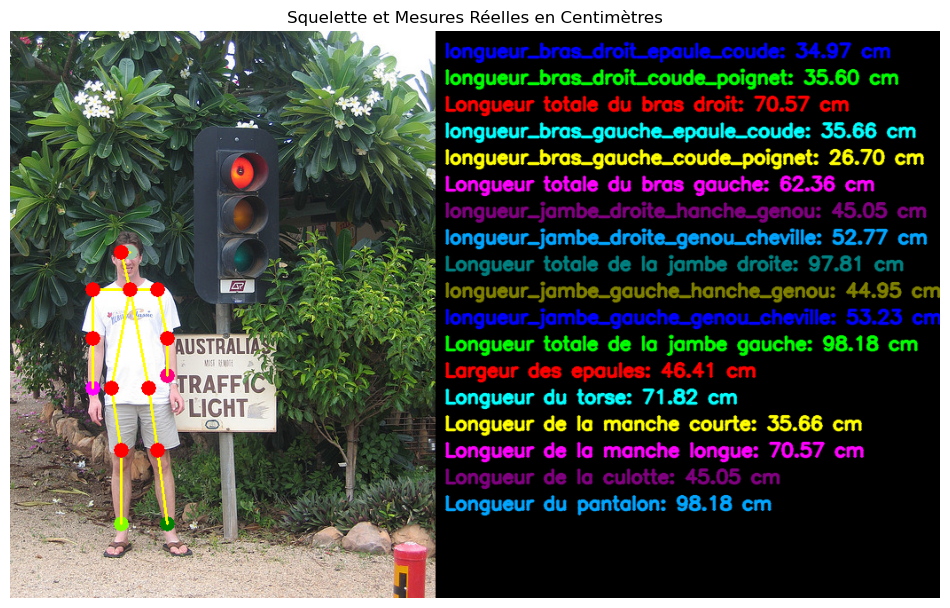

In [42]:
# on demande à l'utilisateur de saisir sa taille réelle
user_real_height = float(input("Veuillez entrer votre taille réelle en cm : "))
taille = max(calculate_distance(points[15], points[13]),calculate_distance(points[14], points[10]) )



# on calcule la hauteur mesurée de l'image (en cm)
image_measured_height = pixels_to_cm(taille,dpi=96)

print(taille,image_measured_height)


# on calcul le facteur d'échelle
scale_factor = user_real_height / image_measured_height
scale_factor *= 1.15505

# on affiche les mesures avant l'image
print("Mesures corporelles réelles en centimètres :")
for idx, (metric, value) in enumerate(body_metrics.items()):
    if value is not None:  # on verifie que la valeur n'est pas None
        cm_value = pixels_to_cm(value, dpi)  # on convertir en cm
        real_measurement = cm_value * scale_factor  # on calcule la mesure réelle
        print(f"{metric}: {real_measurement:.2f} cm")

# on clcule la largeur nécessaire pour l'arrière-plan noir
max_text_width = max([cv2.getTextSize(f"{metric}: {pixels_to_cm(value):.2f} cm", 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0][0] 
                      for metric, value in body_metrics.items() if value is not None], default=0)

black_background_width = max_text_width + 20  # on ajoute un espace supplémentaire

# on cree une image noire avec la largeur calculée
black_background = np.zeros((height, black_background_width, 3), dtype=np.uint8)

# on cree une image combinée avec la largeur ajustée
combined_width = width + black_background_width
combined_image = np.zeros((height, combined_width, 3), dtype=np.uint8)

# on colle l'image avec le squelette à gauche
combined_image[:height, :width] = frameCopy

# on colle l'image noire à droite
combined_image[:height, width:] = black_background

# on affiche les résultats sur l'image noire
y_offset = 30  # on decale vertical pour le texte

for idx, (metric, value) in enumerate(body_metrics.items()):
    if value is not None:  # on verifie que la valeur n'est pas None
        color = colors[idx % len(colors)]  # on chosit une couleur pour chaque mesure
        cm_value = pixels_to_cm(value, dpi)  # on convertis en cm
        real_measurement = cm_value * scale_factor  # on calcule la mesure réelle
        cv2.putText(combined_image, f"{metric}: {real_measurement:.2f} cm", 
                    (width + 10, y_offset + idx * 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, lineType=cv2.LINE_AA)

# on affiche l'image combinée avec les résultats
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # on n'afficher les axes
plt.title('Squelette et Mesures Réelles en Centimètres')
plt.show()


Pour exécuter le code, transformez la  cellule en dessous en cellule de code : le flux vidéo s'affichera en temps réel via cv2.imshow avec les points clés superposés, et dès que l'ensemble des points requis est détecté, le système effectuera une capture automatique sans aucune intervention manuelle. Une fois l'image saisie, elle restera affichée durant 3 secondes pour confirmation avant d'être transmise à la suite du processus, bien que vous puissiez toujours quitter le programme à tout moment en appuyant sur la touche 'q'.

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Variables globales et configuration
points = []
keypoints_names = [
    "Nose", "Neck", "Right Shoulder", "Right Elbow", "Right Wrist",
    "Left Shoulder", "Left Elbow", "Left Wrist", "Right Hip",
    "Right Knee", "Right Ankle", "Left Hip", "Left Knee",
    "Left Ankle", "Chest", "Right Eye", "Left Eye",
    "Right Ear", "Left Ear", "Background"
]

colors = [
    (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),
    (255, 0, 255), (0, 255, 255), (0, 128, 255), (128, 0, 255),
    (255, 128, 0), (128, 255, 0), (0, 255, 128), (0, 0, 128),
    (128, 0, 0), (0, 128, 0), (128, 128, 0), (164, 192, 156),
    (55, 85, 98), (192, 192, 192), (255, 128, 128)
]

# 2. La fonction de détection (indispensable)
def detect_keypoints(frame, net, threshold=0.1):
    global points
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    inWidth = 368
    inHeight = 368

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]
    points = []

    for i in range(18):
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold:
            cv2.circle(frameCopy, (int(x), int(y)), 8, colors[i], thickness=-1, lineType=cv2.FILLED)
            points.append((int(x), int(y)))
        else:
            points.append(None)
    return frameCopy

# 3. Fonction principale
def main():
    global points
    protoFile = "./openpose/models/pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "./openpose/models/pose/coco/pose_iter_440000.caffemodel"
    
    try:
        net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    except Exception as e:
        print(f"Erreur de chargement du modèle : {e}")
        return

    cap = cv2.VideoCapture(0) # Essayez 0 ou 1
    
    if not cap.isOpened():
        print("Erreur : Caméra introuvable ou déjà utilisée.")
        return

    # Préparation de l'affichage Matplotlib
    plt.ion() 
    fig, ax = plt.subplots(figsize=(10, 7))
    im_plot = None

    print("Lecture lancée. Fermez la fenêtre pour arrêter.")

    try:
        while plt.fignum_exists(fig.number):
            ret, frame = cap.read()
            if not ret: break

            # Appel de la fonction définie ci-dessus
            frameWithKeypoints = detect_keypoints(frame, net)
            
            frame_rgb = cv2.cvtColor(frameWithKeypoints, cv2.COLOR_BGR2RGB)

            if im_plot is None:
                im_plot = ax.imshow(frame_rgb)
                plt.axis('off')
            else:
                im_plot.set_data(frame_rgb)
            
            # Message d'état sur le graphique
            required_points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
            missing = [i for i in required_points if i < len(points) and points[i] is None]
            
            ax.set_title(f"Points manquants : {len(missing)}")
            plt.pause(0.01)

    except KeyboardInterrupt:
        print("Arrêt demandé.")
    finally:
        cap.release()
        plt.close('all')
        print("Caméra libérée.")

if __name__ == "__main__":
    main()
